In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
import multiprocessing
from torch import autograd
from fastai.conv_learner import *
from fasterai.images import *
from fasterai.dataset import *
from fasterai.visualize import *
from fasterai.callbacks import *
from fasterai.loss import *
from fasterai.modules import *
from fasterai.wgan import *
from fasterai.generators import *
from fastai.torch_imports import *
from pathlib import Path
from itertools import repeat
import tensorboardX
torch.cuda.set_device(2)
plt.style.use('dark_background')
torch.backends.cudnn.benchmark=True


In [ ]:
DATA_PATH = Path('data/imagenet/ILSVRC/Data/CLS-LOC')
TRAIN_SOURCE_PATH = DATA_PATH/'train'
proj_id = 'bw2color'
TENSORBOARD_PATH = Path('data/tensorboard/Unet_RC1')

dpath = DATA_PATH/(proj_id + '_8222_D.h5')
gpath = DATA_PATH/(proj_id + '_8222_G.h5')
keep_pct=1.0
bs=32
sz=256
wd=1e-7
lr=2e-4
lrs = np.array([lr/1000,lr/100,lr])

torch.backends.cudnn.benchmark=True

## Training

In [ ]:
md = get_matched_image_model_data(image_size=sz, batch_size=bs, root_data_path=DATA_PATH, train_root_path=TRAIN_SOURCE_PATH, proj_id=proj_id, keep_pct=keep_pct)

In [ ]:
netG = Unet34(nf_factor=1).cuda()
netGVis = ModelVisualizationHook(TENSORBOARD_PATH, netG, 'netG')
unet = LearnerGenModuleWrapper(netG, 'unet')
#load_model(netG, gpath)
learn = ConvLearner(md, unet)
imgGenVis = ImageGenVisualizationCallback(TENSORBOARD_PATH, netG, md, 'learner')
learn.metrics = []
learn.opt_fn=optim.Adam
#learn.crit = F.mse_loss #(turns sepia/blurry)
learn.crit = FeatureLoss()

In [ ]:
#learn.freeze_to(1)

In [ ]:
#learn.lr_find(1e-4, 1e1, wds=wd, linear=False)

In [ ]:
#learn.sched.plot(n_skip=0, n_skip_end=0)

In [ ]:
learn.fit(lrs, 1, cycle_len=1, wds=wd, use_clr_beta=(1,8,0.9,0.9), callbacks=[imgGenVis])

In [ ]:
vis = ModelImageVisualizer()

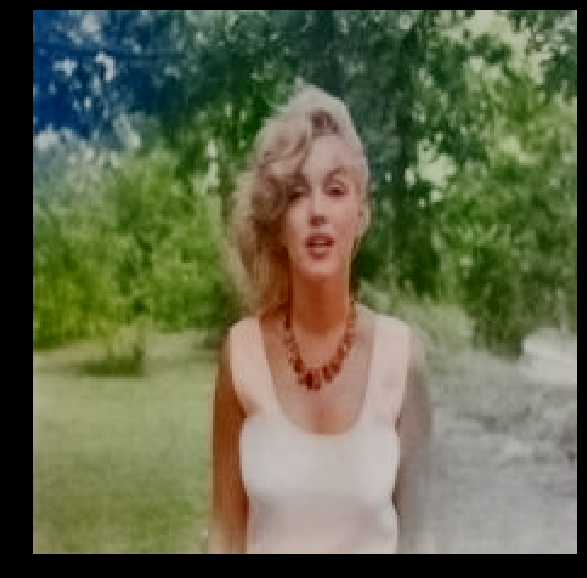

In [120]:
vis.plot_transformed_image("data/uploaded_images/marilyn_woods.jpg", netG, 512)